In [ ]:
"""
SHAP values описывают ожидаемый прирост выходного значения модели при добавлении i-го признака в текущем примере.
"""

In [13]:
import numpy as np
import pandas as pd
import xgboost
import shap
import fasttreeshap
from functools import partial
from sklearn.model_selection import train_test_split

In [14]:
from sklearn.datasets import load_digits
from sklearn.metrics import classification_report

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

In [16]:
from top_contrib_features import calculate_top_contributors, get_feature_class_distance

In [17]:
# train XGBoost model
# X, y = shap.datasets.iris()

# X, y = shap.datasets.adult()
# y = y.astype(int)

X, y = load_digits(return_X_y=True, as_frame=True)
y = y.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, shuffle=True, stratify=y)
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

num_class = len(set(y))

bst = xgboost.train({"learning_rate": 0.1, "objective": 'multi:softprob', 'num_class': num_class}, xgboost.DMatrix(X_train, label=y_train), num_boost_round=30)
print(classification_report(y_true=y_test, y_pred=np.argmax(bst.predict(xgboost.DMatrix(X_test)), axis=1)))

[13:54:40] WARNING: /private/var/folders/rl/_3vj1pms68l3nf_8kr_xl4980000gn/T/pip-install-4tsuk_m3/xgboost_ab2473bd02574d9a9458732cf4ad32e4/build/temp.macosx-11.0-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.96      0.92      0.94        59
           1       0.86      0.83      0.85        60
           2       0.97      0.97      0.97        59
           3       0.88      0.95      0.91        60
           4       0.91      0.97      0.94        60
           5       0.92      0.93      0.93        60
           6       1.00      0.97      0.98        60
           7       0.88      1.00      0.94        59
           8       0.90      0.81      0.85        58
           9       0.91      0.83      0.87      

In [43]:
# explain the model's predictions using SHAP values
n_jobs = 1

# def model_wrapper(data, model):
#     return model.predict(xgboost.DMatrix(data, feature_names=model.feature_names))
#
# explainer = shap.KernelExplainer(partial(model_wrapper, model=bst), X_train[:1000])
# shap_values = np.asarray(explainer.shap_values(X_test))
# shap_values = shap_values.transpose(1, 0, 2)
# base_values = explainer.expected_value

explainer = fasttreeshap.TreeExplainer(bst, algorithm='auto', n_jobs=n_jobs)
shap_values = np.asarray(explainer.shap_values(X_test))
shap_values = shap_values.transpose(1, 0, 2)
base_values = explainer.expected_value

# just the regular predictions
pred_prob = bst.predict(xgboost.DMatrix(X_test))
# or as labels
pred_label = np.argmax(pred_prob, axis=1)

In [44]:
# for just the first observation
vals_0 = calculate_top_contributors(
    base_value=base_values[0], shap_values=shap_values[0, 0, :], features=X_test.iloc[0, :],
    feature_names=bst.feature_names, use_abs=False
)
vals_1 = calculate_top_contributors(
    base_value=base_values[0], shap_values=shap_values[0, 1, :], features=X_test.iloc[0, :],
    feature_names=bst.feature_names, use_abs=False
)

In [45]:
factors_df = get_feature_class_distance(
    base_values=base_values, shap_values=shap_values, feature_names=bst.feature_names,
    X_test=X_test, unique_y=set(y), pred_label=pred_label, y_test=y_test,
    use_abs=False, n_features=None
)

100%|██████████| 594/594 [00:00<00:00, 1434.59it/s]


In [21]:
def plot_histogram(
        data, xlabel='axis OX', ylabel='axis OY', title='Histogram',
        bins=20, label=None, figsize=(16,9), ax=None, q_line_color='red',
        plot_quant=True, add_grid=False,
):
    if ax is None:
        _, ax = plt.subplots(figsize=figsize)

    # Plot histogram
    data.plot(kind="hist", density=True, alpha=0.65, bins=bins, label=f'hist: {label}', ax=ax)  # change density to true, because KDE uses density
    # Plot KDE
    data.plot(kind="kde", label=f'kde: {label}', ax=ax)

    # Quantile lines
    if plot_quant:
        quant_5, quant_25, quant_50, quant_75, quant_95 = data.quantile(0.05), data.quantile(0.25), data.quantile(0.5), data.quantile(0.75), data.quantile(0.95)
        quants = [[quant_5, 0.9, 0.16], [quant_25, 0.9, 0.26], [quant_50, 1, 0.36],  [quant_75, 0.9, 0.46], [quant_95, 0.9, 0.56]]
        for i in quants:
            ax.axvline(i[0], alpha=i[1], ymax=i[2], linestyle=":", color=q_line_color)
        ax.text(quant_5-.1, 0.17, "5th", size=15, alpha=0.9)
        ax.text(quant_25-.13, 0.27, "25th", size=15, alpha=0.9)
        ax.text(quant_50-.13, 0.37, "50th", size=15, alpha=0.9)
        ax.text(quant_75-.13, 0.47, "75th", size=15, alpha=0.9)
        ax.text(quant_95-.25, 0.57, "95th Percentile", size=15, alpha=.9)

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.grid(add_grid)
    ax.set_title(title, size=17, pad=10)

    # Remove ticks and spines
    ax.tick_params(left=False, bottom=False)
    for ax, spine in ax.spines.items():
        spine.set_visible(False)

    return ax

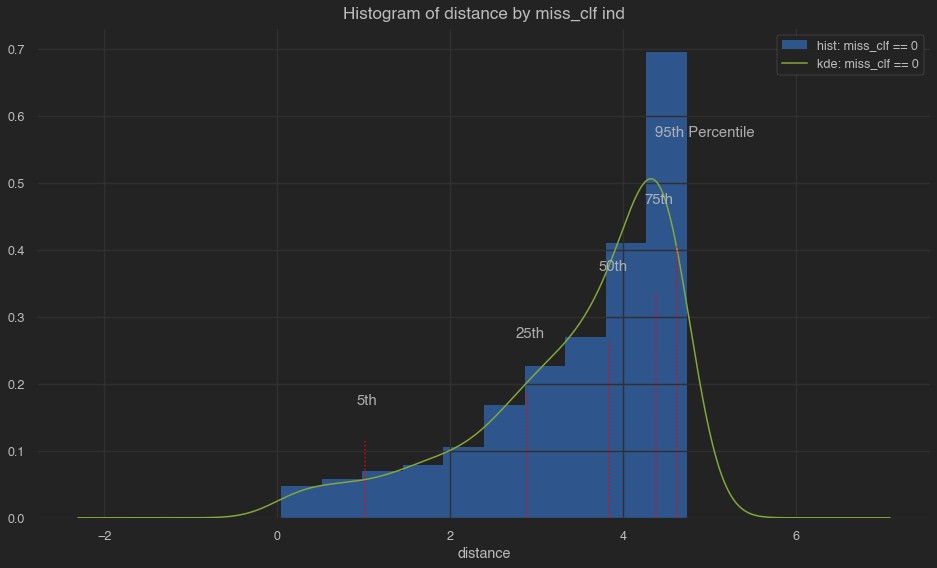

In [22]:
_, ax = plt.subplots(figsize=(16, 9))
plot_histogram(
    factors_df[factors_df['miss_clf'] == 0].distance,
    xlabel='distance', ylabel='', title='Histogram of distance by miss_clf ind',
    bins=10, label='miss_clf == 0', ax=ax, plot_quant=True, add_grid=True
)
ax.legend();

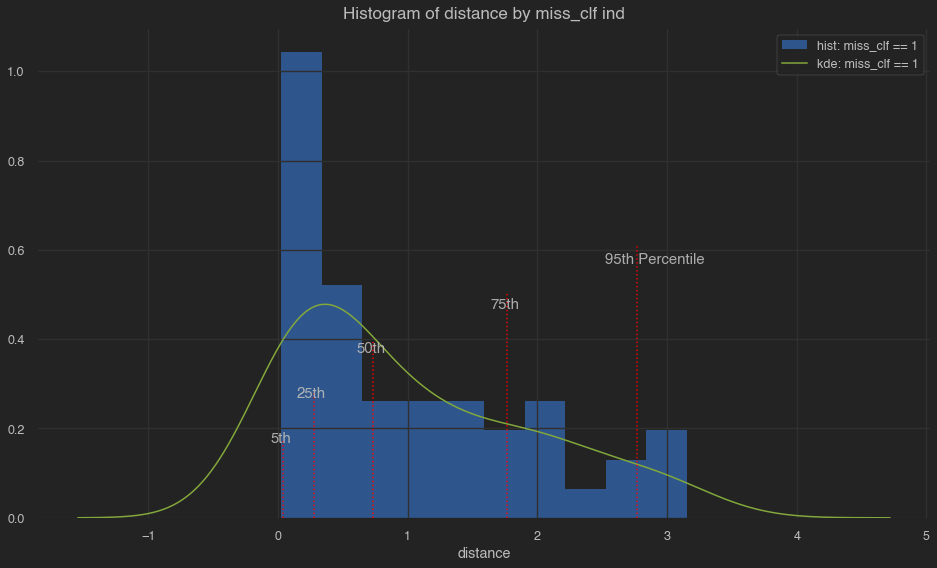

In [23]:
_, ax = plt.subplots(figsize=(16, 9))
plot_histogram(
    factors_df[factors_df['miss_clf'] == 1].distance,
    xlabel='distance', ylabel='', title='Histogram of distance by miss_clf ind',
    bins=10, label='miss_clf == 1', ax=ax, plot_quant=True, add_grid=True
)
ax.legend();

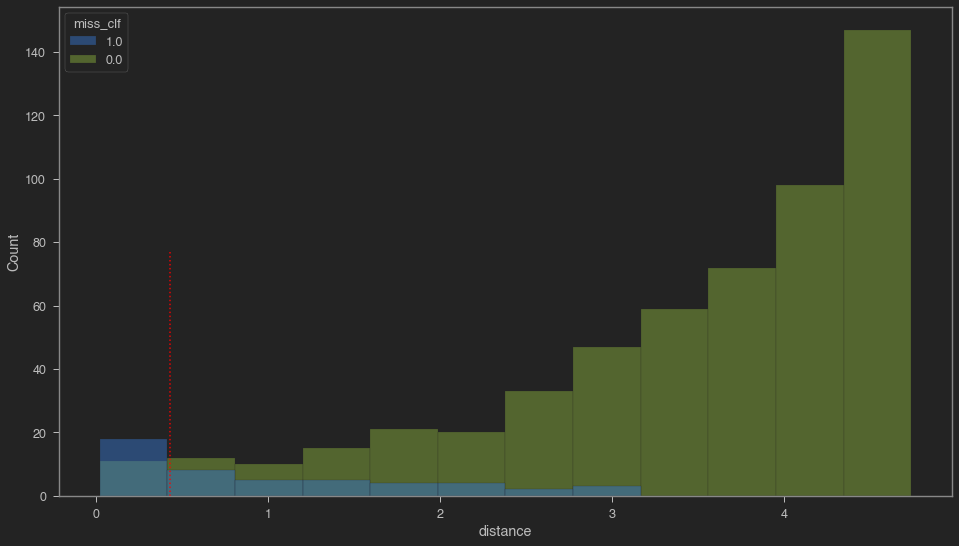

In [60]:

_, ax = plt.subplots(figsize=(16, 9))
q_val = 0.05
ax.axvline(factors_df.distance.quantile(q_val), ymax=0.5, alpha=0.9, linestyle=":", color='red')
sns.histplot(data=factors_df, hue='miss_clf', x='distance', hue_order=[1.0,0.0], ax=ax);